In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Read dataset
df = pd.read_csv('mental_health_sydney_2023.csv')
df['date'] = pd.to_datetime(df['date'])

# Step 2: Create lagged features
df['PM2.5_t-1'] = df['PM2.5'].shift(1)
df['sentiment_score_t-1'] = df['sentiment_score'].shift(1)
df = df.dropna().reset_index(drop=True)

# Step 3: Standardize features
features = ['PM2.5', 'rainfall', 'sentiment_score', 'high_stress_percent', 'PM2.5_t-1', 'sentiment_score_t-1']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Step 4: Split dataset
X = df[features]
y = df['high_risk_day']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 5: Logistic Regression with GridSearchCV
logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_logreg = GridSearchCV(logreg, logreg_params, cv=cv, scoring='f1', n_jobs=-1)
grid_logreg.fit(X_train, y_train)
best_logreg = grid_logreg.best_estimator_

# Step 6: Random Forest with GridSearchCV
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 4, 8],
    'min_samples_split': [2, 4],
    'max_features': ['sqrt']
}
grid_rf = GridSearchCV(rf, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Step 7: Evaluate both models on test set
results = {}
for model_name, model in [('Logistic Regression', best_logreg), ('Random Forest', best_rf)]:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

# Prepare results for display
metrics_df = pd.DataFrame({
    model: {
        'Accuracy': round(res['Accuracy'], 3),
        'F1 Score': round(res['F1 Score'], 3),
        'ROC AUC': round(res['ROC AUC'], 3)
    }
    for model, res in results.items()
}).T

print("Model Evaluation Metrics:")
print(metrics_df)

for model_name, res in results.items():
    print(f"--- {model_name} ---")
    print("Confusion Matrix:")
    print(res['Confusion Matrix'])
    print("\nClassification Report:")
    print(classification_report(y_test, best_logreg.predict(X_test) if model_name == 'Logistic Regression' else best_rf.predict(X_test)))
    print("\n")

Model Evaluation Metrics:
                     Accuracy  F1 Score  ROC AUC
Logistic Regression     0.932     0.444    0.968
Random Forest           0.973     0.800    1.000
--- Logistic Regression ---
Confusion Matrix:
[[66  1]
 [ 4  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       0.67      0.33      0.44         6

    accuracy                           0.93        73
   macro avg       0.80      0.66      0.70        73
weighted avg       0.92      0.93      0.92        73



--- Random Forest ---
Confusion Matrix:
[[67  0]
 [ 2  4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        67
           1       1.00      0.67      0.80         6

    accuracy                           0.97        73
   macro avg       0.99      0.83      0.89        73
weighted avg       0.97      0.97      0.97        73


/var/folders/hq/j1y3fgc95j15c3747fp5n1t80000gn/T/ipykernel_12855/3584137459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


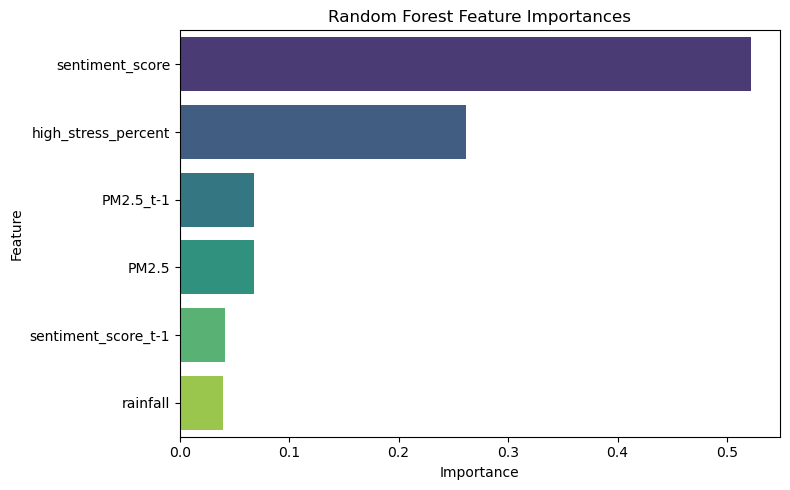

In [3]:
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()